# Built Deep Neural Network in Numpy Step by Step

Previously I trained a 2-layer Neural Network with a single hidden layer. Now I built a deep neural network with as many layers as I want!

- This notebook has all the functions required to build a deep neural network.
- These functions are used to build a deep neural network for image classification.

**Notation**:
- Superscript $[l]$ denotes a quantity associated with the $l^{th}$ layer. 
    - Example: $a^{[L]}$ is the $L^{th}$ layer activation. $W^{[L]}$ and $b^{[L]}$ are the $L^{th}$ layer parameters.
- Superscript $(i)$ denotes a quantity associated with the $i^{th}$ example. 
    - Example: $x^{(i)}$ is the $i^{th}$ training example.
- Lowerscript $i$ denotes the $i^{th}$ entry of a vector.
    - Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the $l^{th}$ layer's activations).


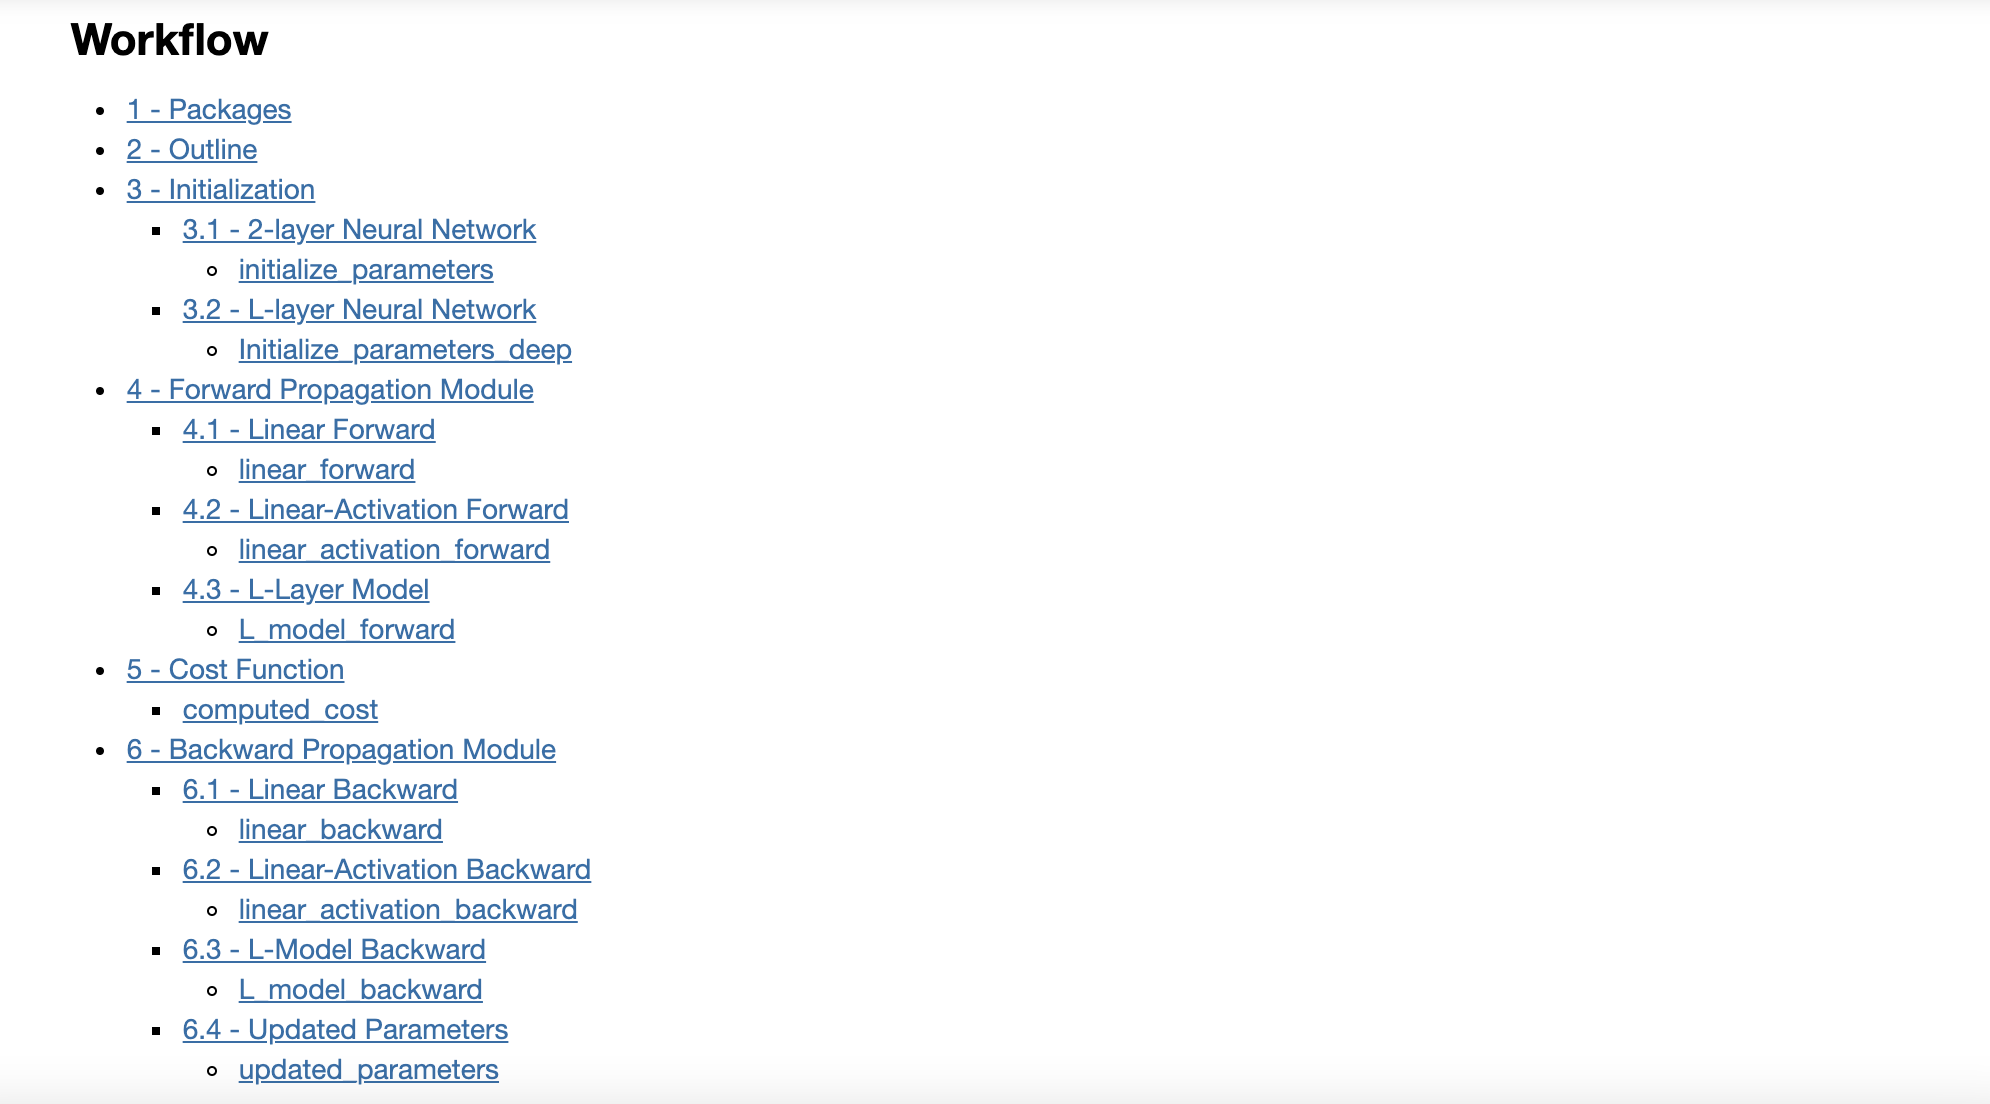

<a name='1'></a>
## 1 - Packages
- np.random.seed(1) is used to keep all the random function calls consistent. 

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # setting default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name='2'></a>
## 2 - Outline

To build neural network, I implemented several "helper functions." These helper functions will be used later to build a two-layer neural network and an L-layer neural network for cat recognition.

- Initialized the parameters for a two-layer network and for an $L$-layer neural network
- Implemented the forward propagation module (shown in purple in the figure below)
     - Completed the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - The ACTIVATION function is used(relu/sigmoid)
     - Combined the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stacked the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and added a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gave a new L_model_forward function.
- Computed the loss
- Implemented the backward propagation module (denoted in red in the figure below)
    - Completed the LINEAR part of a layer's backward propagation step
    - The gradient of the ACTIVATE function is used(relu_backward/sigmoid_backward) 
    - Combined the previous two steps into a new [LINEAR->ACTIVATION] backward function
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally, updated the parameters

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center><b>Figure 1</b></center></caption><br>


**Note**:

For every forward function, there is a corresponding backward function. This is why at every step of your forward module I stored some values in a cache. These cached values are useful for computing gradients. 

In the backpropagation module, I can then use the cache to calculate the gradients. 

<a name='3'></a>
## 3 - Initialization

Two helper functions to initialize the parameters for your model. The first function will be used to initialize parameters for a two layer model. The second one generalizes this initialization process to $L$ layers.

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

<a name='ex-1'></a>
### Initialize_parameters

Created and initialized the parameters of the 2-layer neural network.

**Notes**:

- The model's structure is: *LINEAR -> RELU -> LINEAR -> SIGMOID*. 
- Used this random initialization for the weight matrices: `np.random.randn(shape)*0.01` with the correct shape
- Used zero initialization for the biases: `np.zeros(shape)`

In [2]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    parameters -- python dictionary containing parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    np.random.seed(1)
   
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters    

<a name='3-2'></a>
### 3.2 - L-layer Neural Network

The initialization for a deeper L-layer neural network is more complicated because there are many more weight matrices and bias vectors. When completing the `initialize_parameters_deep` function, I made sure that my dimensions match between each layer. FYI $n^{[l]}$ is the number of units in layer $l$. For example, if the size of my input $X$ is $(12288, 209)$ (with $m=209$ examples) then:

<table style="width:100%">
    <tr>
        <td>  </td> 
        <td> <b>Shape of W</b> </td> 
        <td> <b>Shape of b</b>  </td> 
        <td> <b>Activation</b> </td>
        <td> <b>Shape of Activation</b> </td> 
    <tr>
    <tr>
        <td> <b>Layer 1</b> </td> 
        <td> $(n^{[1]},12288)$ </td> 
        <td> $(n^{[1]},1)$ </td> 
        <td> $Z^{[1]} = W^{[1]}  X + b^{[1]} $ </td> 
        <td> $(n^{[1]},209)$ </td> 
    <tr>
    <tr>
        <td> <b>Layer 2</b> </td> 
        <td> $(n^{[2]}, n^{[1]})$  </td> 
        <td> $(n^{[2]},1)$ </td> 
        <td>$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$ </td> 
        <td> $(n^{[2]}, 209)$ </td> 
    <tr>
       <tr>
        <td> $\vdots$ </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$  </td> 
        <td> $\vdots$</td> 
        <td> $\vdots$  </td> 
    <tr>  
   <tr>
       <td> <b>Layer L-1</b> </td> 
        <td> $(n^{[L-1]}, n^{[L-2]})$ </td> 
        <td> $(n^{[L-1]}, 1)$  </td> 
        <td>$Z^{[L-1]} =  W^{[L-1]} A^{[L-2]} + b^{[L-1]}$ </td> 
        <td> $(n^{[L-1]}, 209)$ </td> 
   <tr>
   <tr>
       <td> <b>Layer L</b> </td> 
        <td> $(n^{[L]}, n^{[L-1]})$ </td> 
        <td> $(n^{[L]}, 1)$ </td>
        <td> $Z^{[L]} =  W^{[L]} A^{[L-1]} + b^{[L]}$</td>
        <td> $(n^{[L]}, 209)$  </td> 
    <tr>
</table>

FYI when computing $W X + b$ in python, it carries out broadcasting. For example, if: 

$$ W = \begin{bmatrix}
    w_{00}  & w_{01} & w_{02} \\
    w_{10}  & w_{11} & w_{12} \\
    w_{20}  & w_{21} & w_{22} 
\end{bmatrix}\;\;\; X = \begin{bmatrix}
    x_{00}  & x_{01} & x_{02} \\
    x_{10}  & x_{11} & x_{12} \\
    x_{20}  & x_{21} & x_{22} 
\end{bmatrix} \;\;\; b =\begin{bmatrix}
    b_0  \\
    b_1  \\
    b_2
\end{bmatrix}\tag{2}$$

Then $WX + b$ will be:

$$ WX + b = \begin{bmatrix}
    (w_{00}x_{00} + w_{01}x_{10} + w_{02}x_{20}) + b_0 & (w_{00}x_{01} + w_{01}x_{11} + w_{02}x_{21}) + b_0 & \cdots \\
    (w_{10}x_{00} + w_{11}x_{10} + w_{12}x_{20}) + b_1 & (w_{10}x_{01} + w_{11}x_{11} + w_{12}x_{21}) + b_1 & \cdots \\
    (w_{20}x_{00} + w_{21}x_{10} + w_{22}x_{20}) + b_2 &  (w_{20}x_{01} + w_{21}x_{11} + w_{22}x_{21}) + b_2 & \cdots
\end{bmatrix}\tag{3}  $$


<a name='ex-2'></a>
### initialize_parameters_deep

Implemented initialization for an L-layer Neural Network. 

**Notes**:
- The model's structure is *[LINEAR -> RELU] $ \times$ (L-1) -> LINEAR -> SIGMOID*. I.e., it has $L-1$ layers using a ReLU activation function followed by an output layer with a sigmoid activation function.
- Used random initialization for the weight matrices. Used `np.random.randn(shape) * 0.01`.
- Used zeros initialization for the biases. Used `np.zeros(shape)`.
- Stored $n^{[l]}$, the number of units in different layers, in a variable `layer_dims`. For example, if  `layer_dims` was [2,4,1] means there are two inputs, one hidden layer with 4 hidden units, and an output layer with 1 output unit. This means `W1`'s shape was (4,2), `b1` was (4,1), `W2` was (1,4) and `b2` was (1,1). Now you will generalize this to $L$ layers! 
- Here is the implementation for $L=1$ (one layer neural network). Based on this, I implemented the general case (L-layer neural network).
```python
    if L == 1:
        parameters["W" + str(L)] = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01
        parameters["b" + str(L)] = np.zeros((layer_dims[1], 1))
```

In [4]:
def initialize_parameters_deep(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))        
        
    return parameters

<a name='4'></a>
## 4 - Forward Propagation Module

<a name='4-1'></a>
### 4.1 - Linear Forward 

After having initialized my parameters, I did the forward propagation module. I started by implementing some basic functions that I can use again later when implementing the model. Now, I'll complete three functions in this order:

- LINEAR
- LINEAR -> ACTIVATION where ACTIVATION will be either ReLU or Sigmoid. 
- [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID (whole model)

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 

<a name='ex-3'></a>
### linear_forward 

Built the linear part of forward propagation.

**Note**:
The mathematical representation of this unit is $Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}$. You may also find `np.dot()` useful. If your dimensions don't match, printing `W.shape` may help.

In [6]:
def linear_forward(A, W, b):
    """
    Implemented the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = W@A + b
    cache = (A, W, b)
    
    return Z, cache

<a name='4-2'></a>
### 4.2 - Linear-Activation Forward

I used two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. `sigmoid` function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what will be fed in to the corresponding backward function). To use it:
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. Relu function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what will be fed in to the corresponding backward function). 
``` python
A, activation_cache = relu(Z)
```

For added convenience, I grouped two functions (Linear and Activation) into one function (LINEAR->ACTIVATION). Hence, you'll implement a function that does the LINEAR forward step, followed by an ACTIVATION forward step.

<a name='ex-4'></a>
### 4 - linear_activation_forward

Implemented the forward propagation of the *LINEAR->ACTIVATION* layer. Mathematical relation is: $A^{[l]} = g(Z^{[l]}) = g(W^{[l]}A^{[l-1]} +b^{[l]})$ where the activation "g" can be sigmoid() or relu(). Used `linear_forward()` 

In [8]:
def linear_activation_forward(A_prev, W, b, activation):
    """
    Implemented the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        Z, linear_cache =  linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache =  linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

**Note**: In deep learning, the "[LINEAR->ACTIVATION]" computation is counted as a single layer in the neural network, not two layers. 

<a name='4-3'></a>
### 4.3 - L-Layer Model 

For even *more* convenience when implementing the $L$-layer Neural Net, I create a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> <b>Figure 2</b> : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>

<a name='ex-5'></a>
### 5 -  L_model_forward

Implemented the forward propagation of the above model.

**Note**: In the code below, the variable `AL` will denote $A^{[L]} = \sigma(Z^{[L]}) = \sigma(W^{[L]} A^{[L-1]} + b^{[L]})$. (This is sometimes also called `Yhat`, i.e., this is $\hat{Y}$.) 


In [10]:
def L_model_forward(X, parameters):
    """
    Implemented forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- activation value from the output (last) layer
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """
    print(parameters)
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implemented [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], "relu")
        caches.append(cache)
    
    # Implemented LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid")
    caches.append(cache)
          
    return AL, caches

**Phew!** I implemented a full forward propagation that takes the input X and outputs a row vector $A^{[L]}$ containing my predictions. It also records all intermediate values in "caches". Using $A^{[L]}$, I can compute the cost of my predictions.

<a name='5'></a>
## 5 - Cost Function

Now I implement forward and backward propagation! I need to compute the cost, in order to check whether my model is actually learning.

<a name='ex-6'></a>
### 6 - compute_cost
Computed the cross-entropy cost $J$, using the following formula: $$-\frac{1}{m} \sum\limits_{i = 1}^{m} (y^{(i)}\log\left(a^{[L] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right)) \tag{7}$$


In [12]:
def compute_cost(AL, Y):
    """
    Implemented the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to my label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    cost = -((Y @ np.log(AL.T)) + (1-Y) @ np.log(1-AL.T))/m
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    return cost

<a name='6'></a>
## 6 - Backward Propagation Module

Similar to forward propagation, I implemented helper functions for backpropagation. Note that backpropagation is used to calculate the gradient of the loss function with respect to the parameters. 

**FYI**: 
<img src="images/backprop_kiank.png" style="width:650px;height:250px;">
<caption><center><font color='purple'><b>Figure 3</b>: Forward and Backward propagation for LINEAR->RELU->LINEAR->SIGMOID <br> <i>The purple blocks represent the forward propagation, and the red blocks represent the backward propagation.</font></center></caption>


<!-- 
For those of you who are experts in calculus (which you don't need to be to do this assignment!), the chain rule of calculus can be used to derive the derivative of the loss $\mathcal{L}$ with respect to $z^{[1]}$ in a 2-layer network as follows:

$$\frac{d \mathcal{L}(a^{[2]},y)}{{dz^{[1]}}} = \frac{d\mathcal{L}(a^{[2]},y)}{{da^{[2]}}}\frac{{da^{[2]}}}{{dz^{[2]}}}\frac{{dz^{[2]}}}{{da^{[1]}}}\frac{{da^{[1]}}}{{dz^{[1]}}} \tag{8} $$

In order to calculate the gradient $dW^{[1]} = \frac{\partial L}{\partial W^{[1]}}$, use the previous chain rule and you do $dW^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial W^{[1]}}$. During backpropagation, at each step you multiply your current gradient by the gradient corresponding to the specific layer to get the gradient you wanted.

Equivalently, in order to calculate the gradient $db^{[1]} = \frac{\partial L}{\partial b^{[1]}}$, you use the previous chain rule and you do $db^{[1]} = dz^{[1]} \times \frac{\partial z^{[1]} }{\partial b^{[1]}}$.

This is why we talk about **backpropagation**.
!-->

Now, similarly to forward propagation, I built the backward propagation in three steps:
1. LINEAR backward
2. LINEAR -> ACTIVATION backward where ACTIVATION computes the derivative of either the ReLU or sigmoid activation
3. [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID backward (whole model)

Some points:

- `b` is a matrix(np.ndarray) with 1 column and n rows, i.e: b = [[1.0], [2.0]] (note that `b` is a constant)
- np.sum performs a sum over the elements of a ndarray
- axis=1 or axis=0 specify if the sum is carried out by rows or by columns respectively
- keepdims specifies if the original dimensions of the matrix must be kept.

<a name='6-1'></a>
### 6.1 - Linear Backward

For layer $l$, the linear part is: $Z^{[l]} = W^{[l]} A^{[l-1]} + b^{[l]}$ (followed by an activation).

Suppose if I have already calculated the derivative $dZ^{[l]} = \frac{\partial \mathcal{L} }{\partial Z^{[l]}}$. I want to get $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$.

<img src="images/linearback_kiank.png" style="width:250px;height:300px;">
<caption><center><font color='purple'><b>Figure 4</b></font></center></caption>

The three outputs $(dW^{[l]}, db^{[l]}, dA^{[l-1]})$ are computed using the input $dZ^{[l]}$.

Formulas needed:
$$ dW^{[l]} = \frac{\partial \mathcal{J} }{\partial W^{[l]}} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} \tag{8}$$
$$ db^{[l]} = \frac{\partial \mathcal{J} }{\partial b^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{[l](i)}\tag{9}$$
$$ dA^{[l-1]} = \frac{\partial \mathcal{L} }{\partial A^{[l-1]}} = W^{[l] T} dZ^{[l]} \tag{10}$$


$A^{[l-1] T}$ is the transpose of $A^{[l-1]}$. 

<a name='ex-7'></a>
### 7 - linear_backward 

Used the 3 formulas above to implement `linear_backward()`.

In [15]:

def linear_backward(dZ, cache):
    """
    Implemented the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = (dZ @ A_prev.T)/m
    db = np.mean(dZ, axis = 1, keepdims=True)
    dA_prev = W.T @ dZ
    
    return dA_prev, dW, db

<a name='6-2'></a>
### 6.2 - Linear-Activation Backward

Next, I created a function that merges the two helper functions: **`linear_backward`** and the backward step for the activation **`linear_activation_backward`**. 

To help implement `linear_activation_backward`, two backward functions were used:
- **`sigmoid_backward`**: Implements the backward propagation for SIGMOID unit:

```python
dZ = sigmoid_backward(dA, activation_cache)
```

- **`relu_backward`**: Implements the backward propagation for RELU unit:

```python
dZ = relu_backward(dA, activation_cache)
```

If $g(.)$ is the activation function, 
`sigmoid_backward` and `relu_backward` compute $$dZ^{[l]} = dA^{[l]} * g'(Z^{[l]}). \tag{11}$$  

<a name='ex-8'></a>
### 8 -  linear_activation_backward

Implemented the backpropagation for the *LINEAR->ACTIVATION* layer.

In [17]:
def linear_activation_backward(dA, cache, activation):
    """
    Implemented the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
       
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

<a name='6-3'></a>
### 6.3 - L-Model Backward 

Then I implemented the backward function for the whole network! 

FYI when I implemented the `L_model_forward` function, at each iteration, I stored a cache which contains (X,W,b, and z). In the back propagation module, I'll use those variables to compute the gradients. Therefore, in the `L_model_backward` function, I'll iterate through all the hidden layers backward, starting from layer $L$. On each step, I will use the cached values for layer $l$ to backpropagate through layer $l$. Figure 5 below shows the backward pass. 


<img src="images/mn_backward.png" style="width:450px;height:300px;">
<caption><center><font color='purple'><b>Figure 5</b>: Backward pass</font></center></caption>

**Initializing backpropagation**:

To backpropagate through this network, output is: 
$A^{[L]} = \sigma(Z^{[L]})$. My code thus needs to compute `dAL` $= \frac{\partial \mathcal{L}}{\partial A^{[L]}}$.
To do so, used this ready made formula from lecture):
```python
dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) # derivative of cost with respect to AL
```

Used this post-activation gradient `dAL` to keep going backward. As seen in Figure 5, I can now feed in `dAL` into the LINEAR->SIGMOID backward function I implemented (which will use the cached values stored by the L_model_forward function). 

After that, I used a `for` loop to iterate through all the other layers using the LINEAR->RELU backward function. I stored each dA, dW, and db in the grads dictionary. To do so, used this formula : 

$$grads["dW" + str(l)] = dW^{[l]}\tag{15} $$

For example, for $l=3$ this would store $dW^{[l]}$ in `grads["dW3"]`.

<a name='ex-9'></a>
### 9 -  L_model_backward

Implemented backpropagation for the *[LINEAR->RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model.

In [19]:
def L_model_backward(AL, Y, caches):
    """
    Implemented the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
 
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    # Looping from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
        current_cache = caches[0]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, 'relu')
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    return grads

<a name='6-4'></a>
### 6.4 - Update Parameters

Then I updated the parameters of the model, using gradient descent: 

$$ W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \tag{16}$$
$$ b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]} \tag{17}$$

where $\alpha$ is the learning rate. 

After computing the updated parameters, I stored them in the parameters dictionary. 

<a name='ex-10'></a>
### 10 - update_parameters

Implemented `update_parameters()` to update your parameters using gradient descent.

**Notes**:
Updated parameters using gradient descent on every $W^{[l]}$ and $b^{[l]}$ for $l = 1, 2, ..., L$. 

In [22]:
def update_parameters(params, grads, learning_rate):
    """
    Updated parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing parameters 
    grads -- python dictionary containing gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    # Updated rule for each parameter. Used a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

### Phew! 

I implemented all the functions required for building a deep neural network, including: 

- Using non-linear units to improve model
- Building a deeper neural network (with more than 1 hidden layer)
- Implementing an easy-to-use neural network class

Then I use these functions to build two models to classify cats vs non-cats:

- A two-layer neural network
- An L-layer neural network